# <center> Using the Euler Characteristic Transform on Protein Data </center>

### <center> Sarah Percival </center>
<center> Department of Biochemistry and Molecular Biology, Michigan State University </center>

# Welcome
This notebook focuses on the Euler Characteristic Transform. Email perciva9@msu.edu with questions or comments.

# Goals
* Apply the Euler Characteristic Transform (ECT) to protein data
* Make efficient, scalable computations

In [6]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

In [3]:
# This command allows us to zoom and drag plots.
%matplotlib notebook

In [9]:
protein = pd.read_csv("../GFP/AF-W6KDG8-F1-model_v3.pdb", delim_whitespace = True, header = None)

In [8]:
# protein2 = pd.read_csv("../PPI/1ppi.pdb", delim_whitespace = True, header = None)

In [5]:
protein

,0,1,2,3,4,5,6,7,8,9,10,11
0,ATOM,1,N,MET,A,1,12.424,-0.957,-20.746,1.0,74.69,N
1,ATOM,2,CA,MET,A,1,11.638,-1.841,-19.858,1.0,74.69,C
2,ATOM,3,C,MET,A,1,12.612,-2.767,-19.150,1.0,74.69,C
3,ATOM,4,CB,MET,A,1,10.581,-2.641,-20.637,1.0,74.69,C
4,ATOM,5,O,MET,A,1,13.635,-3.088,-19.750,1.0,74.69,O
...,...,...,...,...,...,...,...,...,...,...,...,...
1893,ATOM,1894,CG,LYS,A,238,13.764,6.939,-25.135,1.0,61.75,C
1894,ATOM,1895,CD,LYS,A,238,12.823,6.675,-26.313,1.0,61.75,C
1895,ATOM,1896,CE,LYS,A,238,11.458,6.243,-25.774,1.0,61.75,C
1896,ATOM,1897,NZ,LYS,A,238,10.429,6.246,-26.840,1.0,61.75,N


In [10]:
protein2

,0,1,2,3,4,5,6,7,8,9,10,11
0,ATOM,1,N,GLN,A,1,16.966,60.160,15.437,1.0,44.40,N
1,ATOM,2,CA,GLN,A,1,16.021,59.570,14.522,1.0,43.22,C
2,ATOM,3,C,GLN,A,1,16.643,58.461,13.700,1.0,41.16,C
3,ATOM,4,O,GLN,A,1,16.169,57.359,13.903,1.0,40.05,O
4,ATOM,5,CB,GLN,A,1,15.433,60.665,13.610,1.0,45.93,C
...,...,...,...,...,...,...,...,...,...,...,...,...
3903,ATOM,3904,CB,LEU,A,496,45.216,30.869,15.257,1.0,17.89,C
3904,ATOM,3905,CG,LEU,A,496,44.568,29.759,16.110,1.0,17.38,C
3905,ATOM,3906,CD1,LEU,A,496,43.510,30.280,17.045,1.0,14.46,C
3906,ATOM,3907,CD2,LEU,A,496,43.986,28.741,15.176,1.0,18.09,C


In [15]:
# select the entire backbone
CA_backbone = protein2[protein2[2].isin(['N','C','CA'])]

In [16]:
# select the alpha carbon backbone only. The fewer the points we select here, the faster our computations are.
# CA_backbone = protein[protein[2].isin(['CA'])]

Think about how the ECT might change if we included all nitrogen and carbon atoms. We'll discuss this in class Tuesday.

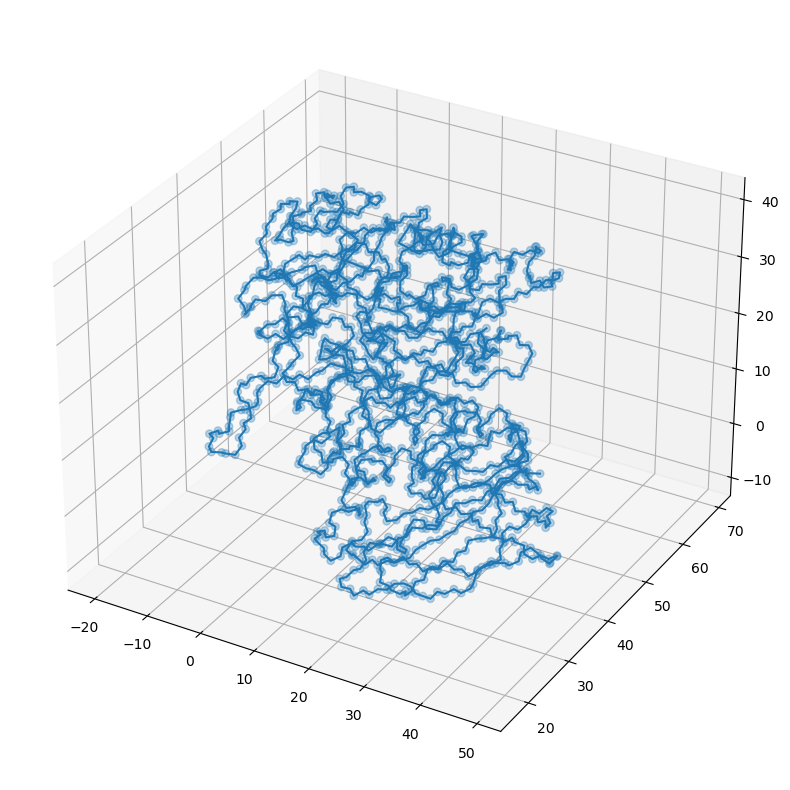

In [17]:
# the atoms are in order in the PDB files, so we connect adjacent atoms
fig1 = plt.figure(figsize=(10,10))
ax = fig1.add_subplot(projection='3d')

ax.scatter(CA_backbone[6].tolist(), CA_backbone[7].tolist(), CA_backbone[8].tolist(), s=30, alpha=0.3)
ax.plot3D(CA_backbone[6].tolist(), CA_backbone[7].tolist(), CA_backbone[8].tolist())

plt.show();

If you can't see the plot above, try running the cell below.

In [ ]:
%matplotlib inline

# Euler Characteristic Transform

Persistent homology is computationally expensive. This means that the calculations required to compute it are complex and take a long time. If we want to analyze 200 million proteins, we may need something that is more simple computationally. That's where the Euler Characteristic Transform, or ECT, comes in.

In [8]:
# this function computes the Euler Characteristic curve in the given direction
# need to choose an appropriate start and end

def compute_ecc(data, start_time, end_time, normal):
    """Computes the Euler characteristic curve along a given direction.

    Direction is given by normal vector. Begin by computing the dot product of the normal vector with the starting
    point. Incrementally increase starting vector to sweep along normal.
    
    A plane is given by the equation a*x+b*y+c*z+d=0 where [a,b,c] is the normal. [x, y, z] is the point that
    intersects the plane. Thus, we have to calculate d to find all points such that a*x+b*y+c*z+d<0.
    
    Subtract the number of edges from the number of points to obtain the Euler characteristic at each timestamp.

    Parameters
    ----------
    data : array-like

        Input point cloud. Points are assumed to be in order.
        
    end_time : scalar
    
        Start time is assumed to be 0. End time is the maximum value that the starting point is multiplied by.
        
    starting_point: array-like
    
        This is the center of the first plane
        
    normal: array-like
    
        The direction along which to sweep the plane

    Returns
    -------
    ecc : list

        The Euler characteristic curve in the given direction.
    """

    ecc = []

    for i in np.linspace(0,end_time,100):
        point  = i*normal+start_time*normal

        d = -point.dot(normal)
        
        # find all points below the given plane
        sublevel_pts = np.where(data.dot(normal) + d < 0)[0]
        
        # find connected components (connected components will have consecutive vertices)
        consec_vertices = np.split(sublevel_pts, np.where(np.diff(sublevel_pts) != 1)[0]+1)
        # the number of edges is one less than the length of the consecutive vertices
        edges = sum([len(j)-1 for j in consec_vertices])
        points = len(sublevel_pts)
        
        # the above step is coded in a way such that if there are no points, there are -1 edges, which we don't want
        # if there are no points, there should be 0 edges
        if edges < 0:
            edges = 0
        # compute Euler characteristic
        ecc.append(points-edges)
        
    return ecc

How can the efficiency of the above function be improved? Use the cell magic %%timeit to test any improvements.

Now it's time to apply the ECT to our data!

In [9]:
protein_ecc = compute_ecc(np.array(CA_backbone[[6,7,8]]), # select columns 6, 7, 8 which contain the coordinates
                          -30, # this is the start time. If your curve does not start with 0s, make this smaller
                          60, # this is the end time. If your curve does not end with 1s, make this bigger
                          np.array([0,0,1])) # this is the direction the plane moves in

You want the protein_ecc vector to start with 0 and end with 1, but if there are a lot of 0s at the beginning make the start time larger, and if there are a lot of 1s at the end, make the end time smaller. Now we plot the protein_ecc curve below.

<IPython.core.display.Javascript object>


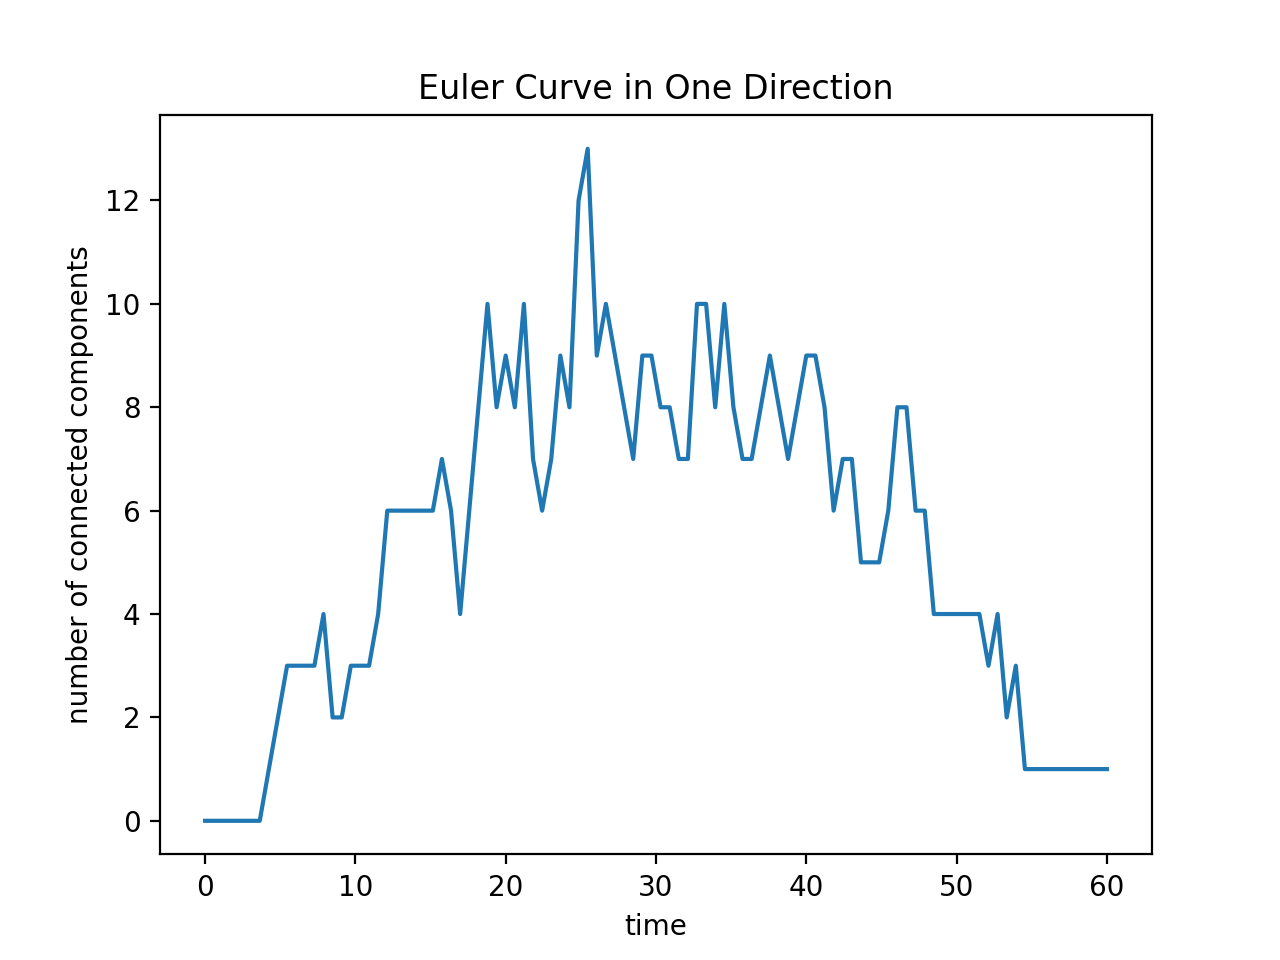

In [10]:
fig2 = plt.figure()

# plotting the points 
plt.plot(np.linspace(0,60,100), protein_ecc) # the first and last numbers are always 0 and 100, but the middle
# number should be your end_time

# naming the x axis
plt.xlabel('time')
# naming the y axis
plt.ylabel('number of connected components')

# giving a title to my graph
plt.title('Euler Curve in One Direction');

Select a different angle.

In [11]:
# now let's choose the angle [3,-2,4]
# notice we have to change the start and end times

protein_ecc2 = compute_ecc(np.array(CA_backbone[[6,7,8]]), # select columns 6, 7, 8 which contain the coordinates
                          -5, # this is the start time. If your curve does not start with 0s, make this smaller
                          10, # this is the end time. If your curve does not end with 1s, make this bigger
                          np.array([3,-2,4])) # this is the direction the plane moves in

<IPython.core.display.Javascript object>


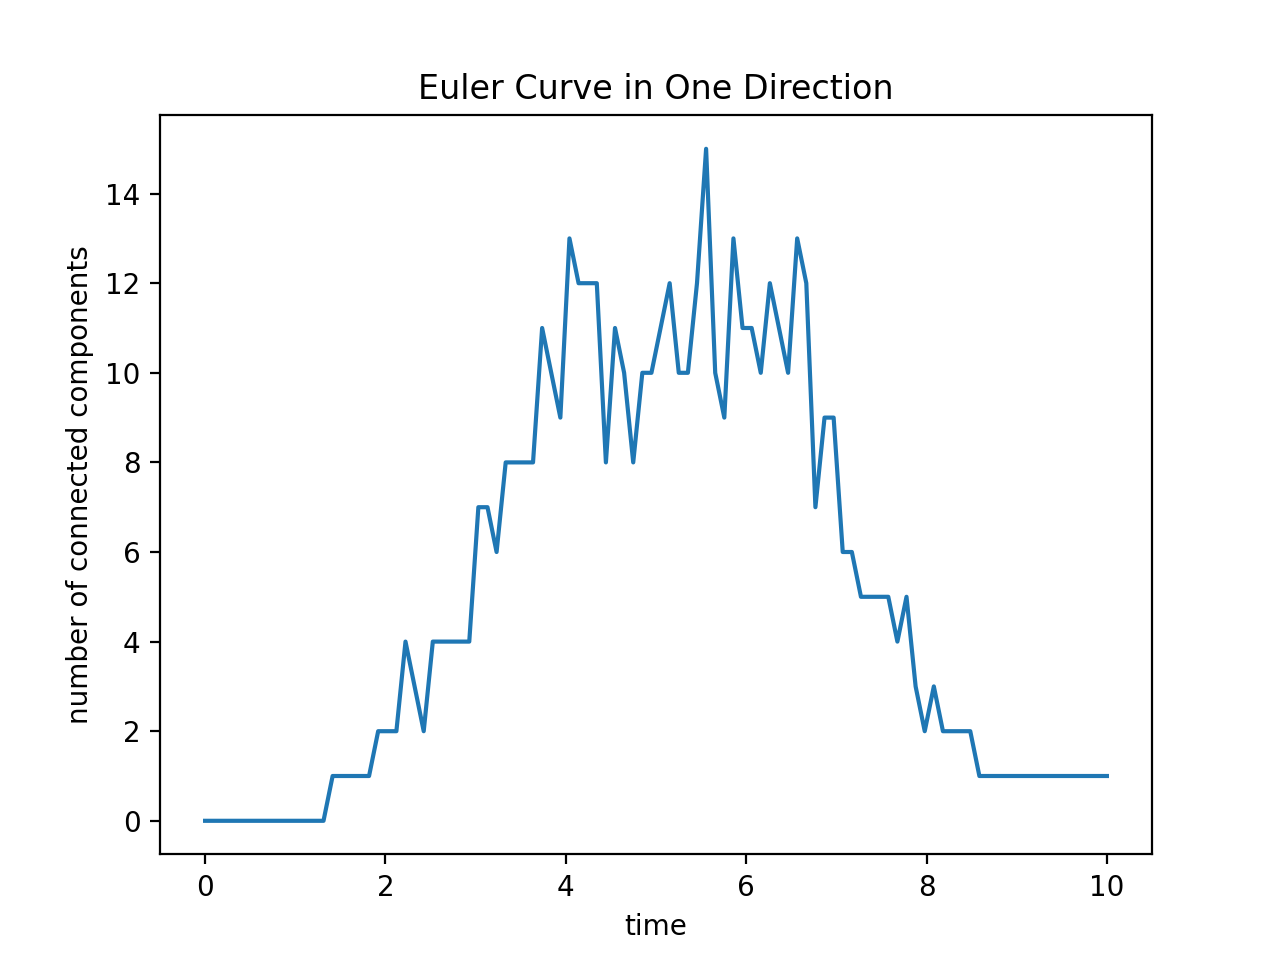

In [12]:
fig3 = plt.figure()

# plotting the points 
plt.plot(np.linspace(0,10,100), protein_ecc2) # the first and last numbers are always 0 and 100, but the middle
# number should be your end_time

# naming the x axis
plt.xlabel('time')
# naming the y axis
plt.ylabel('number of connected components')

# giving a title to my graph
plt.title('Euler Curve in One Direction');

In [13]:
plt.close()

Repeat the above three cells 3 more times with different angles, for a total of five different angles. How are the plots for each curve different? How are they similar? There are no wrong answers!

Once you have the curves for several different angles, try appending them together.

In [ ]:
# Solution: will discuss in class
long_vector = protein_ecc+protein_ecc2

In [20]:
# Solution 2 with numpy:
long_vector = np.concatenate((np.array(protein_ecc), np.array(protein_ecc2)), axis=None)

array([ 0,  0,  0,  0,  0,  0,  0,  1,  2,  3,  3,  3,  3,  4,  2,  2,  3,
        3,  3,  4,  6,  6,  6,  6,  6,  6,  7,  6,  4,  6,  8, 10,  8,  9,
        8, 10,  7,  6,  7,  9,  8, 12, 13,  9, 10,  9,  8,  7,  9,  9,  8,
        8,  7,  7, 10, 10,  8, 10,  8,  7,  7,  8,  9,  8,  7,  8,  9,  9,
        8,  6,  7,  7,  5,  5,  5,  6,  8,  8,  6,  6,  4,  4,  4,  4,  4,
        4,  3,  4,  2,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
        2,  2,  2,  4,  3,  2,  4,  4,  4,  4,  4,  7,  7,  6,  8,  8,  8,
        8, 11, 10,  9, 13, 12, 12, 12,  8, 11, 10,  8, 10, 10, 11, 12, 10,
       10, 12, 15, 10,  9, 13, 11, 11, 10, 12, 11, 10, 13, 12,  7,  9,  9,
        6,  6,  5,  5,  5,  5,  4,  5,  3,  2,  3,  2,  2,  2,  2,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

Bonus: use the cell magic %%timeit to test the time it takes to compute the ecc for the backbone vs. just the alpha carbons.

In [ ]:
# Solution:

In [21]:
%%timeit

CA_backbone = protein[protein[2].isin(['N','C','CA'])]

protein_ecc = compute_ecc(np.array(CA_backbone[[6,7,8]]), # select columns 6, 7, 8 which contain the coordinates
                          -30, # this is the start time. If your curve does not start with 0s, make this smaller
                          60, # this is the end time. If your curve does not end with 1s, make this bigger
                          np.array([0,0,1])) # this is the direction the plane moves in

4.19 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%timeit

CA_backbone = protein[protein[2].isin(['CA'])]

protein_ecc = compute_ecc(np.array(CA_backbone[[6,7,8]]), # select columns 6, 7, 8 which contain the coordinates
                          -30, # this is the start time. If your curve does not start with 0s, make this smaller
                          60, # this is the end time. If your curve does not end with 1s, make this bigger
                          np.array([0,0,1])) # this is the direction the plane moves in

3.59 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1]:
test1 = [1, 2, 3, 4]

In [2]:
test2 = [4, 5, 6, 7]

In [3]:
[x+y for x,y in zip(test1, test2)]

[5, 7, 9, 11]